1. Import các thư viện

In [2]:
import os
import numpy as np
import cv2
import pyheif

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

2. Data processing

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
# Hàm đọc dữ liệu từ thư mục (bao gồm cả training và validation)
def load_dataset_from_dir(data_dir, img_size=(224,224)):
    X, y = [], []
    classes = sorted(d for d in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, d)))
    label_map = {cls:i for i,cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png','heic','jfif','heif')):  # Thêm các định dạng ảnh
                path = os.path.join(cls_dir, fname)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float16) / 255.0
                X.append(img)
                y.append(cls)

    X = np.array(X)
    y = np.array(y)

    return X, y, label_map


# Đọc dữ liệu từ Google Drive
dataset_path_train = '/gdrive/MyDrive/DoAN/Bai05/Dataset/train'
dataset_path_val = '/gdrive/MyDrive/DoAN/Bai05/Dataset/val'

X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(224,224))
X_val, y_val, label_map_val = load_dataset_from_dir(dataset_path_val, img_size=(224,224))

print(f"Tổng số ảnh trong tập TRAIN: {len(X_train)}")
print(f"Tổng số ảnh trong tập VALIDATION: {len(X_val)}")


Tổng số ảnh trong tập TRAIN: 4282
Tổng số ảnh trong tập VALIDATION: 1225


In [5]:
# Encode nhãn và chia dữ liệu train/test
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
num_classes = len(le.classes_)

print(y_train_num)

[0 0 0 ... 9 9 9]


In [8]:
# One-hot encode Y
Y_train = to_categorical(y_train_num, num_classes)
Y_val = to_categorical(y_val, num_classes)

print(Y_train)
print(Y_val)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


3. Xây dựng model

In [9]:
# Load pre-train model VGG
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các lớp của VGG
for layer in vgg16.layers:
    layer.trainable = False

# Thêm các lớp mới cho bài toán phân loại
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Tạo mô hình mới từ VGG16 + các lớp phân loại mới
model = Model(inputs=vgg16.input, outputs=output)

model.summary()

# Compile mô hình
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

4. Huấn luyện model

In [12]:
# training
H = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3272s 24s/step - accuracy: 0.2411 - loss: 2.5744 - val_accuracy: 0.5731 - val_loss: 1.4598
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3294s 24s/step - accuracy: 0.4244 - loss: 1.5447 - val_accuracy: 0.6776 - val_loss: 1.1725
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3221s 24s/step - accuracy: 0.4665 - loss: 1.4170 - val_accuracy: 0.7404 - val_loss: 0.9673
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3142s 23s/step - accuracy: 0.5430 - loss: 1.2530 - val_accuracy: 0.7069 - val_loss: 0.9866
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3235s 24s/step - accuracy: 0.5648 - loss: 1.1823 - val_accuracy: 0.8016 - val_loss: 0.7637
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3248s 24s/step - accuracy: 0.5746 - loss: 1.1044 - val_accuracy: 0.7927 - val_loss: 0.7169
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3217s 24s/step - accuracy: 0.6086 - loss: 1.0363 - val_accuracy: 0.8253 - val_loss: 0.6509
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3277s 24s/step - accuracy: 0.6207 - loss: 0

In [13]:
import numpy as np
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(H.history['val_accuracy']) + 1
best_train_epoch = np.argmax(H.history['accuracy']) + 1
best_val_accuracy = H.history['val_accuracy'][best_epoch - 1]
best_train_accuracy = H.history['accuracy'][best_train_epoch - 1]
print(f"Best val_accuracy: {best_epoch} với val_accuracy = {best_val_accuracy:.4f}")
print(f"Best train_accuracy: {best_train_epoch} với train_accuracy = {best_train_accuracy:.4f}")

Best val_accuracy: 10 với val_accuracy = 0.8457
Best train_accuracy: 10 với train_accuracy = 0.6562


In [14]:
# Lưu mô hình vào Google Drive
model_save_path = '/gdrive/MyDrive/DoAN/Model 2/handwritten_digit.h5'
model.save(model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to /gdrive/MyDrive/DoAN/Model 2/handwritten_digit.h5


5. Visualization

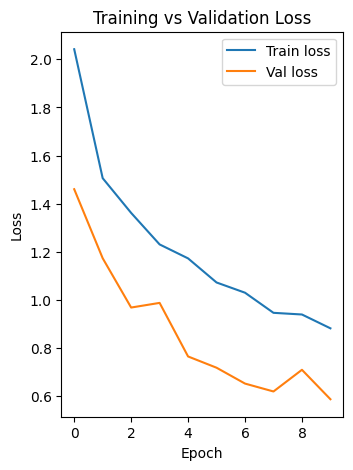

<function matplotlib.pyplot.show(close=None, block=None)>

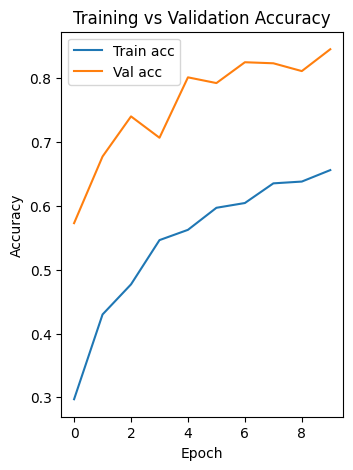

In [15]:
# 12. Vẽ đồ thị loss và accuracy của training & validation
# Loss
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='Train loss')
plt.plot(H.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='Train acc')
plt.plot(H.history['val_accuracy'], label='Val acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show


6.  Dự đoán trên dữ liệu

In [ ]:
import os
import cv2
import numpy as np

# Hàm dự đoán và lưu kết quả
def predict_and_save_results(model, data_dir, img_size=(224,224)):
    X, filenames = [], []

    # Kiểm tra lại img_size có đúng định dạng không
    if not isinstance(img_size, tuple) or len(img_size) != 2:
        raise ValueError(f"img_size phai co 2 phan tu. Hien tai la {img_size}")

    # Duyệt qua tất cả các file trong thư mục dữ liệu
    for fname in os.listdir(data_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png','.heic','.jfif')):  # Lọc các ảnh
            path = os.path.join(data_dir, fname)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đổi sang RGB

            # Resize hình ảnh về kích thước 224x224
            img = cv2.resize(img, img_size)  # Resize ảnh
            img = img.astype(np.float16) / 255.0  # Chuẩn hóa ảnh
            X.append(img)
            filenames.append(fname)

    # Chuyển X thành mảng numpy
    X = np.array(X)

    # Dự đoán nhãn
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)  # Lấy nhãn có xác suất cao nhất

    # Lưu kết quả vào file CSV với định dạng tên file và nhãn
    result_file = '/gdrive/MyDrive/DoAN/Model 2/predictions.csv'  # Đường dẫn mới lưu kết quả vào Google Drive
    os.makedirs(os.path.dirname(result_file), exist_ok=True)  # Đảm bảo thư mục tồn tại

    with open(result_file, 'w') as f:
        for fname, predicted_class in zip(filenames, predicted_classes):
            # Đảm bảo giữ nguyên tên file đầy đủ (bao gồm phần mở rộng)
            f.write(f"{fname},{predicted_class}\n")

    print(f"Results saved to {result_file}")

# Dự đoán cho bộ test từ Google Drive
dataset_path_test = '/gdrive/MyDrive/DoAN/Bai05/data.2025'
predict_and_save_results(model, dataset_path_test)
